In [ ]:
!git clone https://github.com/princetonvisualai/ContextualBias.git

Cloning into 'ContextualBias'...
remote: Enumerating objects: 1057, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 1057 (delta 46), reused 9 (delta 5), pack-reused 974
Receiving objects: 100% (1057/1057), 1.01 MiB | 7.57 MiB/s, done.
Resolving deltas: 100% (648/648), done.


In [ ]:
root = './'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ContextualBias

/content/ContextualBias


In [ ]:
#cd /content/drive/MyDrive/ContextualBiasStacking/CAMs/

In [ ]:
ls

AwA/                  evaluate_unrel.py           recall.py
biased_categories.py  get_cams.py                 split_80_20.py
classifier.py         get_prediction_examples.py  train.py
COCOStuff/            job.sh                      UnRel/
DeepFashion/          load_data.py                weight_similarity.py
evaluate.py           README.md


In [ ]:
import numpy as np
import PIL
import torch
import sys
import os
import cv2
import argparse
import matplotlib.pyplot as plt
import torchvision.transforms as T

from PIL import Image
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from classifier import multilabel_classifier
from load_data import *

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict

def zero_out_CAM(heatmap, zero_out, binarize=True):
    threshold = np.percentile(heatmap, float(zero_out))
    print('threshold: ', threshold)                                                                                                                                                                                                          
    #print('np.max(heatmap): ', np.max(heatmap))                                                                                                                                                                                              

    if not binarize: 
      heatmap[heatmap<=threshold]=0
      return heatmap
    if binarize:
      return heatmap<=threshold
    #return heatmap


'''def get_heatmap(CAM_map, img):
    CAM_map = cv2.resize(CAM_map, (img.shape[0], img.shape[1]))
    CAM_map = CAM_map - np.min(CAM_map)
    CAM_map = CAM_map / np.max(CAM_map)
    CAM_map = 1.0 - CAM_map # make sure colormap is not reversed
    heatmap = cv2.applyColorMap(np.uint8(255 * CAM_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap + np.float32(img)
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.uint8(255 * heatmap)
    return heatmap'''

def get_heatmap(CAM_map, img):
    CAM_map = cv2.resize(CAM_map, (img.shape[0], img.shape[1]))
    CAM_map = CAM_map - np.min(CAM_map)
    CAM_map = CAM_map / np.max(CAM_map)
    CAM_map = 1.0 - CAM_map # make sure colormap is not reversed
    CAM_map = zero_out_CAM(CAM_map, zero_out=10)
    heatmap = cv2.applyColorMap(np.uint8(255 * CAM_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    # only apply img when relevant 
    CAM_map = np.repeat(CAM_map[:, :, np.newaxis], 3, axis=2)
    img = np.multiply(np.float32(img), CAM_map>0)
    print('img shape: ', img.shape)
    print('heatmap shape: ', heatmap.shape)
    heatmap = heatmap + np.float32(img)
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.uint8(255 * heatmap)
    
    return heatmap

def returnCAM(feature_conv, weight_softmax, class_labels, device):
    bz, nc, h, w = feature_conv.shape # (1, hidden_size, height, width)
    output_cam = torch.Tensor(0, 7, 7).to(device=device)
    for idx in class_labels:
        cam = torch.mm(weight_softmax[idx].unsqueeze(0), feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - cam.min()
        cam_img = cam / cam.max()
        output_cam = torch.cat([output_cam, cam_img.unsqueeze(0)], dim=0)
    return output_cam

In [ ]:
ls /content/drive/MyDrive/ContextualBiasStacking/CAMs/models

model_20.pth  model_99.pth


In [ ]:
arg = {}
arg['modelpath_standard'] = '/content/drive/MyDrive/ContextualBiasStacking/CAMs/models/model_99.pth'
arg['modelpath_weighted'] = '/content/drive/MyDrive/ContextualBiasStacking/CAMs/models/model_20.pth'
arg['img_ids'] = ['000000549220'] # exclusive skateboard image
arg['outdir'] = '/content/drive/MyDrive/ContextualBiasStacking/CAMs/results/'
arg['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
arg['dtype'] = torch.float32

In [ ]:
# Get image class labels
prev_img_labels = pickle.load(open('/content/drive/MyDrive/ContextualBiasStacking/CAMs/labels_test.pkl', 'rb'))
# preprocess img_labels and change the path names
img_labels = {}
for old_key in prev_img_labels.keys():
  new_key=old_key.split('/')[-1][:-4]
  img_labels[new_key] = prev_img_labels[old_key]


In [ ]:
humanlabels_to_onehot = pickle.load(open('/content/drive/MyDrive/ContextualBiasStacking/CAMs/humanlabels_to_onehot.pkl', 'rb'))
arg['dataset'] = 'COCOStuff'                                                                                                                              
biased_classes_mapped = pickle.load(open('/content/drive/MyDrive/ContextualBiasStacking/CAMs/biased_classes_mapped.pkl', 'rb'))
onehot_to_humanlabels = {v: k for k,v in humanlabels_to_onehot.items()}

In [ ]:
def get_cam(img_id, b, model):
  normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  transform = T.Compose([
      T.Resize(224),
      T.CenterCrop(224),
      T.ToTensor()
  ])
  classifier_features = []
  def hook_classifier_features(module, input, output):
      classifier_features.append(output)

  classifier = multilabel_classifier(device=arg['device'], dtype=arg['dtype'], modelpath=model)
  classifier.model = classifier.model.to(device=classifier.device, dtype=classifier.dtype)

  classifier.model._modules['resnet'].layer4.register_forward_hook(hook_classifier_features)
  classifier_params = list(classifier.model.parameters())
  classifier_softmax_weight = classifier_params[-2].squeeze(0)
  print(img_id)
  img_path = '/content/drive/MyDrive/ContextualBiasStacking/CAMs/imgs/{}'.format(img_id)
  img_name = img_path.split('/')[-1][:-4]
  print('img_name: ', img_name)
  original_img = Image.open(img_path).convert('RGB')

  if arg['outdir'] != None:
      outdir = '{}/{}'.format(arg['outdir'], img_id)
  else:
      outdir = str(img_id)

  if not os.path.exists(outdir):
    os.makedirs(outdir)

  print('Processing img {}'.format(img_id), flush=True)

  if img_name in img_labels:
      print('img_path in img_labels')
      if torch.cuda.device_count() > 0:
          class_labels = img_labels[img_name].type('torch.cuda.ByteTensor')
      else:
          class_labels = img_labels[img_name].type('torch.ByteTensor')
  
  class_labels = torch.flatten(torch.nonzero(class_labels))
  classifier_features.clear()
  img = transform(original_img)
  norm_img = normalize(img)
  norm_img = norm_img.to(device=classifier.device, dtype=classifier.dtype)
  norm_img = norm_img.unsqueeze(0)
  x = classifier.forward(norm_img)
  
  
  # for b in biased_classes_mapped.keys():    
    #if b==68: # microwave                                                                                                                             
    #if b in class_labels:                                                                                                                   
                                                                                                                        
  
  # b = 36#  skateboard
  c = biased_classes_mapped[b]   
  class_labels = torch.tensor([b, c])                                                                                                               
  
  
  CAMs = returnCAM(classifier_features[0], classifier_softmax_weight, class_labels, arg['device'])
  CAMs = CAMs.detach().cpu().numpy()

  # Save CAM heatmap
  img = np.moveaxis(img.detach().cpu().numpy(), 0, -1)
  class_labels = class_labels.cpu().detach().numpy()

  heatmap_b = get_heatmap(CAMs[0], img)
  heatmap_c = get_heatmap(CAMs[1], img)
  return heatmap_b, heatmap_c
  '''plt.figure()
  plt.imshow(heatmap)
  plt.axis('off')
  plt.title(onehot_to_humanlabels[class_labels[0]])
  humanlabel = onehot_to_humanlabels[class_labels[0]].replace(' ', '+')
  #plt.savefig('{}/{}_{}.png'.format(outdir, img_name, humanlabel))
  plt.show()
  plt.close()
  '''


In [ ]:
'''biased_classes_list = list(biased_classes_mapped.keys())

for k in range(len(biased_classes_list)):
    b = biased_classes_list[k]
    c = biased_classes_mapped[b]

    cooccur = (labels_list[:,b]==1) & (labels_list[:,c]==1)
    exclusive = (labels_list[:,b]==1) & (labels_list[:,c]==0)
    '''

'biased_classes_list = list(biased_classes_mapped.keys())\n\nfor k in range(len(biased_classes_list)):\n    b = biased_classes_list[k]\n    c = biased_classes_mapped[b]\n\n    cooccur = (labels_list[:,b]==1) & (labels_list[:,c]==1)\n    exclusive = (labels_list[:,b]==1) & (labels_list[:,c]==0)\n    '

In [ ]:
# given img id array, return results (avg MSE and avg L2 distance)
def get_results(img_ids):
  results = defaultdict(int)
  n = len(img_ids)
  print('n: ', n)
  
  for img_id in img_ids:
    hmap_b_stnd, hmap_c_stnd = get_cam(img_id, b=36, model=arg['modelpath_standard'])
    hmap_b_wgtd, hmap_c_wgtd = get_cam(img_id, b=36, model=arg['modelpath_weighted'])
    print(hmap_b_stnd.shape)
    hmap_b_stnd, hmap_c_stnd, hmap_b_wgtd, hmap_c_wgtd = np.ravel(hmap_b_stnd), np.ravel(hmap_c_stnd), np.ravel(hmap_b_wgtd), np.ravel(hmap_c_wgtd)
    print(hmap_b_stnd, hmap_b_wgtd)
    b_mse = mean_squared_error(hmap_b_stnd, hmap_b_wgtd)
    c_mse = mean_squared_error(hmap_c_stnd, hmap_c_wgtd)
    b_dist = euclidean_distances(np.expand_dims(hmap_b_stnd, axis=0), np.expand_dims(hmap_b_wgtd, axis=0))
    c_dist = euclidean_distances(np.expand_dims(hmap_c_stnd, axis=0), np.expand_dims(hmap_c_wgtd, axis=0))

    results['b_mse'] += b_mse
    results['c_mse'] += c_mse
    results['b_dist'] += b_dist
    results['c_dist'] += c_dist

  print('results before: ', results)
  for k in results.keys():
    results[k] = results[k]/n
  print('results after: ', results)
  
  return results

In [ ]:
co_occur = os.listdir('/content/drive/MyDrive/ContextualBiasStacking/CAMs/skateboardperson_cooccur/')
co_occur_results = get_results(co_occur)
print(co_occur_results)

n:  5
COCO_val2014_000000315338.jpg
img_name:  COCO_val2014_000000315338
Processing img COCO_val2014_000000315338.jpg
img_path in img_labels
threshold:  0.0810108631849289
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.12882700562477112
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
COCO_val2014_000000315338.jpg
img_name:  COCO_val2014_000000315338
Processing img COCO_val2014_000000315338.jpg
img_path in img_labels
threshold:  0.047871045768260956
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.12407172471284866
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
(224, 224, 3)
[85  0  0 ... 85  0  0] [85  0  0 ... 85  0  0]
COCO_val2014_000000128699.jpg
img_name:  COCO_val2014_000000128699
Processing img COCO_val2014_000000128699.jpg
img_path in img_labels
threshold:  0.027897290885448456
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.04583783447742462
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3

In [ ]:
exclusive = os.listdir('/content/drive/MyDrive/ContextualBiasStacking/CAMs/skateboardperson_exclusive/')
exclusive_results = get_results(exclusive)
print(exclusive_results)

n:  3
COCO_val2014_000000292789.jpg
img_name:  COCO_val2014_000000292789
Processing img COCO_val2014_000000292789.jpg
img_path in img_labels
threshold:  0.021069638431072235
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.03743349015712738
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
COCO_val2014_000000292789.jpg
img_name:  COCO_val2014_000000292789
Processing img COCO_val2014_000000292789.jpg
img_path in img_labels
threshold:  0.021194927394390106
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.02026812732219696
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
(224, 224, 3)
[111   0   0 ... 111   0   0] [111   0   0 ... 111   0   0]
COCO_val2014_000000549220.jpg
img_name:  COCO_val2014_000000549220
Processing img COCO_val2014_000000549220.jpg
img_path in img_labels
threshold:  0.05917060375213623
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.0564228817820549
img shape:  (224, 224, 3)
heatmap shape:  

In [ ]:
def get_all(img_ids, results, version='Exclusive'):
  for img_id in img_ids:
    result =  {}
    hmap_b_stnd, hmap_c_stnd = get_cam(img_id, b=36, model=arg['modelpath_standard'])
    hmap_b_wgtd, hmap_c_wgtd = get_cam(img_id, b=36, model=arg['modelpath_weighted'])
    plt.imshow(hmap_b_stnd)
    plt.show()
    hmap_b_stnd, hmap_c_stnd, hmap_b_wgtd, hmap_c_wgtd = np.ravel(hmap_b_stnd), np.ravel(hmap_c_stnd), np.ravel(hmap_b_wgtd), np.ravel(hmap_c_wgtd)
    b_mse = mean_squared_error(hmap_b_stnd, hmap_b_wgtd)
    c_mse = mean_squared_error(hmap_c_stnd, hmap_c_wgtd)
    b_dist = euclidean_distances(np.expand_dims(hmap_b_stnd, axis=0), np.expand_dims(hmap_b_wgtd, axis=0))
    c_dist = euclidean_distances(np.expand_dims(hmap_c_stnd, axis=0), np.expand_dims(hmap_c_wgtd, axis=0))

    result['hmap_b_stnd'] = hmap_b_stnd
    result['hmap_c_stnd'] = hmap_c_stnd
    result['hmap_b_wgtd'] = hmap_b_wgtd
    result['hmap_c_wgtd'] = hmap_c_wgtd
    
    result['b_mse'] = b_mse
    result['c_mse'] = c_mse
    result['b_dist'] = b_dist[0][0]
    result['c_dist'] = c_dist[0][0]
    result['version'] = version

    results[img_id] = result

  return results 

In [ ]:
def order_img_ids(results, order='b_dist'):
  # create an order based on the order
  value_to_orderby = []
  img_id_ordered = []
  
  for img_id in results.keys():
    value_to_orderby.append(np.float(results[img_id][order]))
    img_id_ordered.append(img_id)

  img_ids_ordered = np.array(img_id_ordered)[np.array(np.argsort(value_to_orderby))]
  return img_ids_ordered



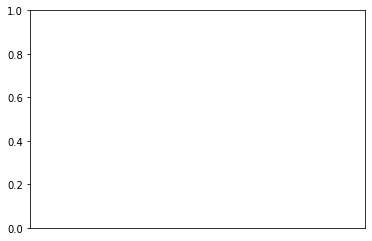

In [ ]:
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

In [ ]:
def zero_out(heatmap, zero_out, binarize):
    threshold = np.percentile(heatmap, float(zero_out))
    print('threshold: ', threshold)                                                                                                                                                                                                          
    #print('np.max(heatmap): ', np.max(heatmap))                                                                                                                                                                                              

    if not binarize: 
      heatmap[heatmap<=threshold]=0
      return heatmap
    if binarize:
      return heatmap<=threshold
    #return heatmap

COCO_val2014_000000315338.jpg
img_name:  COCO_val2014_000000315338
Processing img COCO_val2014_000000315338.jpg
img_path in img_labels
threshold:  0.3277977705001831
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.41685950756073
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
COCO_val2014_000000315338.jpg
img_name:  COCO_val2014_000000315338
Processing img COCO_val2014_000000315338.jpg
img_path in img_labels
threshold:  0.2188255786895752
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.3923700451850891
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)


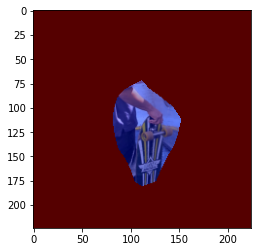

COCO_val2014_000000128699.jpg
img_name:  COCO_val2014_000000128699
Processing img COCO_val2014_000000128699.jpg
img_path in img_labels
threshold:  0.26466646790504456
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.31266266107559204
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
COCO_val2014_000000128699.jpg
img_name:  COCO_val2014_000000128699
Processing img COCO_val2014_000000128699.jpg
img_path in img_labels
threshold:  0.2891620993614197
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.36815741658210754
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)


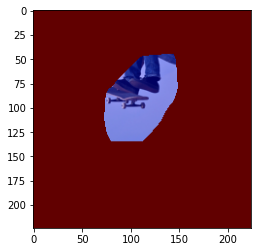

COCO_val2014_000000563680.jpg
img_name:  COCO_val2014_000000563680
Processing img COCO_val2014_000000563680.jpg
img_path in img_labels
threshold:  0.2058875560760498
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.09827977418899536
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
COCO_val2014_000000563680.jpg
img_name:  COCO_val2014_000000563680
Processing img COCO_val2014_000000563680.jpg
img_path in img_labels
threshold:  0.15600714087486267
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.1068572998046875
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)


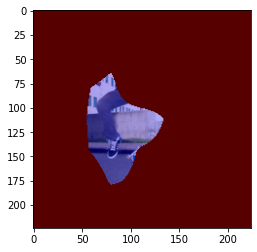

COCO_val2014_000000292789.jpg
img_name:  COCO_val2014_000000292789
Processing img COCO_val2014_000000292789.jpg
img_path in img_labels
threshold:  0.19577041268348694
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.11837732791900635
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
COCO_val2014_000000292789.jpg
img_name:  COCO_val2014_000000292789
Processing img COCO_val2014_000000292789.jpg
img_path in img_labels
threshold:  0.20323166251182556
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.12960851192474365
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)


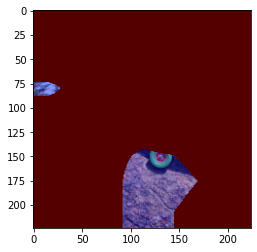

COCO_val2014_000000549220.jpg
img_name:  COCO_val2014_000000549220
Processing img COCO_val2014_000000549220.jpg
img_path in img_labels
threshold:  0.34926292300224304
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.3630044460296631
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
COCO_val2014_000000549220.jpg
img_name:  COCO_val2014_000000549220
Processing img COCO_val2014_000000549220.jpg
img_path in img_labels
threshold:  0.40754279494285583
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.3719291687011719
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)


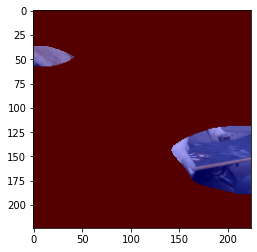

COCO_val2014_000000449327.jpg
img_name:  COCO_val2014_000000449327
Processing img COCO_val2014_000000449327.jpg
img_path in img_labels
threshold:  0.24407479166984558
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.3759285509586334
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
COCO_val2014_000000449327.jpg
img_name:  COCO_val2014_000000449327
Processing img COCO_val2014_000000449327.jpg
img_path in img_labels
threshold:  0.16809886693954468
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)
threshold:  0.2730564475059509
img shape:  (224, 224, 3)
heatmap shape:  (224, 224, 3)


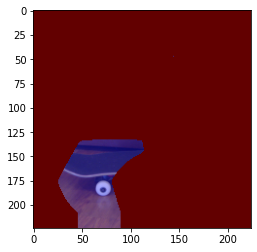

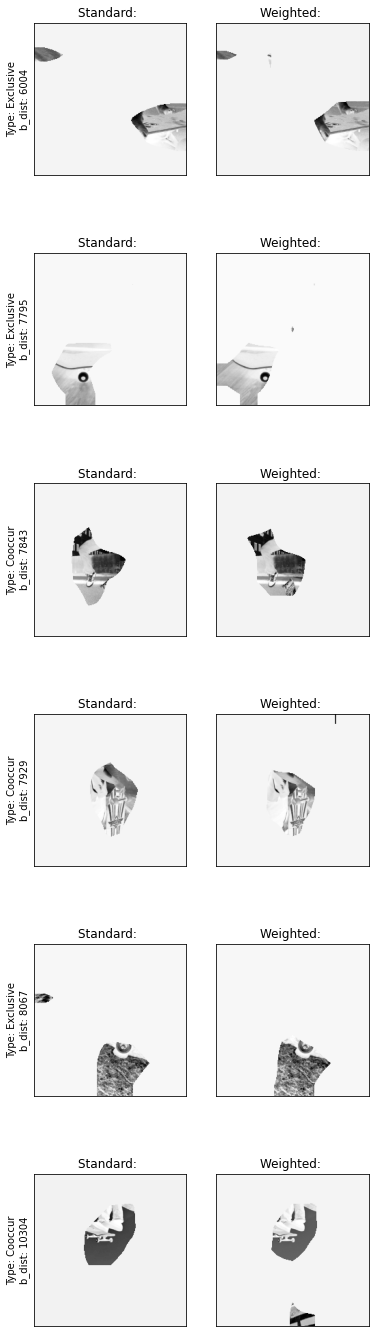

In [ ]:
order = 'b_dist'
zero_out_arg = 0
binarize=False

# given img id array, return results (avg MSE and avg L2 distance)
results = {}
results = get_all(co_occur[0:3], results, version='Cooccur')
results = get_all(exclusive, results, version='Exclusive')

img_ids_ordered = order_img_ids(results, order=order)

# plot 
fig=plt.figure(figsize=(6, 24))
columns = 2
rows = len(img_ids_ordered)
orderby_b=True
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.tight_layout()
if order[0]=='b':
  weighted_heatmap = 'hmap_b_wgtd'
  standard_heatmap = 'hmap_b_stnd'
else:
  weighted_heatmap = 'hmap_c_wgtd'
  standard_heatmap = 'hmap_c_stnd'

standard = True
for i in range(1, columns*rows +1):
  img_id = img_ids_ordered[int((i-1)/2)]
  # if even, plot weighted
  if i%2==0:
    img = results[img_id][weighted_heatmap]

    standard = False
  # plot standard
  else:
    img = results[img_id][standard_heatmap]
    standard = True
  
  def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
  img = img.reshape((224, 224, 3))
  img = np.squeeze(rgb2gray(img))
  #img = zero_out(img, zero_out_arg, binarize)
  
  fig.add_subplot(rows, columns, i)
  
  if standard: title='Standard: '
  else: title='Weighted: '
  #if i%2==0: 
    #title += order + ": " + str(int(results[img_id][order]))
  #else: #standard 
    #title += results[img_id]['version']
  if standard:
    plt.ylabel('Type: '+results[img_id]['version'] + '\n' +  order + ": " + str(int(results[img_id][order]))) 
  plt.title(title)
  plt.xticks([], [])
  plt.yticks([], [])
  # plt.axis('off')
  plt.imshow(img[:, :], cmap='Greys')
  #plt.imshow(img[:, :])

plt.show()


In [ ]:
co_occur_results

defaultdict(int,
            {'b_dist': array([[10121.85422699]]),
             'b_mse': 59.77334449404763,
             'c_dist': array([[7028.48464937]]),
             'c_mse': 45.27848107993198})

In [ ]:
exclusive_results

defaultdict(int,
            {'b_dist': array([[10542.82537851]]),
             'b_mse': 60.212124433106574,
             'c_dist': array([[10099.69687665]]),
             'c_mse': 51.443926268424036})

In [ ]:
from PIL import Image
from pycocotools.coco import COCO

cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
anns_img = np.zeros((img['height'],img['width']))
for ann in anns:
    anns_img = np.maximum(anns_img,coco.annToMask(ann)*ann['category_id'])

NameError: ignored